In [1]:
import arviz as az
import pandas as pd
import json

import numpy as np
import diffrax
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import sys
from scipy.stats import mode

sys.path.append("../models/")
from huang_ferrell_1996 import *
from bhalla_iyengar_1999 import *
from kholodenko_2000 import *
from levchenko_2000 import *
from brightman_fell_2000 import *
from schoeberl_2002 import *
from hatakeyama_2003 import *
from hornberg_2005 import *
from birtwistle_2007 import *
from orton_2009 import *
from vonKriegsheim_2009 import *
from shin_2014 import *
from ryu_2015 import *
from kochanczyk_2017 import *
from dessauges_2022 import *

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('~/.matplotlib/custom.mplstyle')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
from plotting_helper_funcs import *

sys.path.insert(0, '../param_est/')
from sampling_utils import *

rng = np.random.default_rng(seed=1234)

/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_smc_samples_to_idata(samples_json):
    """ Load SMC samples from json file to arviz InferenceData object """
    with open(samples_json, 'r') as f:
        data = json.load(f)
    
    # create idata object from dictionary
    # ignore sample stats because that changes with each SMC chain
    idata = az.from_dict(
        posterior =  data['posterior'],
        posterior_attrs = data['posterior_attrs'],
        # sample_stats = data['sample_stats'],
        observed_data = data['observed_data'],
        observed_data_attrs = data['observed_data_attrs'],
        log_likelihood = data['log_likelihood'],
        log_likelihood_attrs = data['log_likelihood_attrs'],
        constant_data = data['constant_data'],
        constant_data_attrs = data['constant_data_attrs'],
        attrs = data['attrs'],
    )

    sample_stats = data['sample_stats']

    return idata, sample_stats

## Synthetic Data

In [3]:
# Kholodenko 2000
K_2000_idata, K_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/kholodenko_2000/kholodenko_2000_smc_samples.json')
K_2000_post = np.load('../../../results/MAPK/param_est/synthetic_data/kholodenko_2000/kholodenko_2000_posterior_predictive_samples.npy')
# Levchenko 2000
L_2000_idata, L_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/levchenko_2000/levchenko_2000_smc_samples.json')
L_2000_post = np.load('../../../results/MAPK/param_est/synthetic_data/levchenko_2000/levchenko_2000_posterior_predictive_samples.npy')
# Hatakeyama 2003
HK_2003_idata, HK_2003_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/hatakeyama_2003/hatakeyama_2003_smc_samples.json')
HK_2003_post = np.load('../../../results/MAPK/param_est/synthetic_data/hatakeyama_2003/hatakeyama_2003_posterior_predictive_samples.npy')
# Hornberg 2005
H_2005_idata, H_2005_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/hornberg_2005/hornberg_2005_smc_samples.json') # TODO: add once smc is done
H_2005_post = np.load('../../../results/MAPK/param_est/synthetic_data/hornberg_2005/hornberg_2005_posterior_predictive_samples.npy')
# Birtwistle 2007
B_2007_idata, B_2007_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/birtwistle_2007/birtwistle_2007_smc_samples.json')
B_2007_post = np.load('../../../results/MAPK/param_est/synthetic_data/birtwistle_2007/birtwistle_2007_posterior_predictive_samples.npy')
# Orton 2009
O_2009_idata, O_2009_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/orton_2009/orton_2009_smc_samples.json') # TODO: add once smc is done
O_2009_post = np.load('../../../results/MAPK/param_est/synthetic_data/orton_2009/orton_2009_posterior_predictive_samples.npy')
# von Kreigsheim 2009
# vK_2009_idata, ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/von_kreigsheim_2009/von_kreigsheim_2009_smc_samples.json') # TODO: add once smc is done
# vK_2009_post = np.load('../../../results/MAPK/param_est/synthetic_data/von_kreigsheim_2009/von_kreigsheim_2009_posterior_predictive_samples.npy')
# Shin 2014
S_2014_idata, S_2014_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/shin_2014/shin_2014_smc_samples.json')
S_2014_post = np.load('../../../results/MAPK/param_est/synthetic_data/shin_2014/shin_2014_posterior_predictive_samples.npy')
# Ryu 2015
R_2015_idata, R_2015_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/ryu_2015/ryu_2015_smc_samples.json') # TODO: add once smc is done
R_2015_post = np.load('../../../results/MAPK/param_est/synthetic_data/ryu_2015/ryu_2015_posterior_predictive_samples.npy')
# Kochańczyk 2017
K_2017_idata, K_2017_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/kochanczyk_2017/kochanczyk_2017_smc_samples.json') # TODO: add once smc is done
K_2017_post = np.load('../../../results/MAPK/param_est/synthetic_data/kochanczyk_2017/kochanczyk_2017_posterior_predictive_samples.npy')

model_names = ['kholodenko_2000', 'levchenko_2000', 'hatakeyama_2003','hornberg_2005', 'birtwistle_2007', 'orton_2009', 'shin_2014', 'ryu_2015', 'kochanczyk_2017']
display_names = ['Kholodenko 2000', 'Levchenko 2000', 'Katakeyama 2003','Hornberg 2005', 'Birtwistle 2007', 'Orton 2009', 'Shin 2014', 'Ryu 2015', 'Kochańczyk 2017']

# gather posterior samples
posterior_samples = [K_2000_post, L_2000_post, HK_2003_post, H_2005_post, B_2007_post, O_2009_post, S_2014_post, R_2015_post, K_2017_post]
shin_id = 4
# shin has 16000 so downsample to 4000
idxs = rng.choice(np.arange(16000), size=4000, replace=False)
posterior_samples[shin_id] = S_2014_post[idxs]

# get data
inputs, data = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')

# set up a color palette
colors = sns.color_palette('pastel', n_colors=len(model_names)+2)

# sns.color_palette("husl", len(model_names)+2)

#### Remake posterior predictive dose repsonse in a more compact form

In [4]:
def plot_stimulus_response_curve(samples, data, inputs, box_color='k', data_color='r', input_name='EGF stimulus', 
                                 output_name='% maximal ERK activity',
                                 data_std=0.1, width=6.0, height=3.0, scatter_marker_size=50, data_marker_size=7):
    dat = {}
    for i,input in enumerate(inputs):
        dat[input] = samples[:,i]

    data_df = pd.DataFrame(dat)

    fig, ax = plt_func.get_sized_fig_ax(width, height)
    sns.boxplot(data=data_df, color=box_color, ax=ax, whis=(2.5, 97.5), fill=True, 
                native_scale=True, log_scale=(10, 0), fliersize=0, width=0.65)
    ax.set_xlabel(input_name)
    ax.set_ylabel(output_name)

    errors = data_std*np.squeeze(np.ones_like(data))
    ax.scatter(inputs, data, color=data_color, marker='x', s=scatter_marker_size, zorder=10, label='synthetic data')
    ax.errorbar(inputs, np.squeeze(data), yerr=errors, color=data_color, fmt='x', markersize=data_marker_size, zorder=10)

    return fig, ax

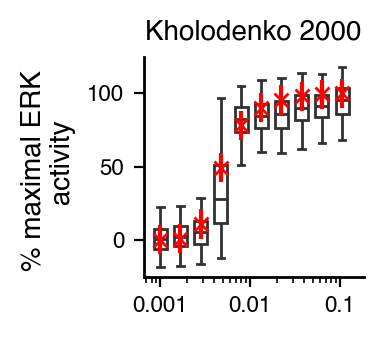

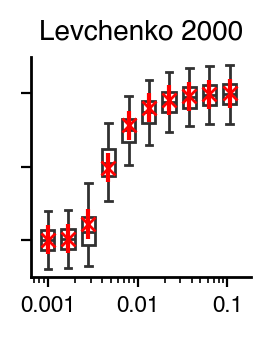

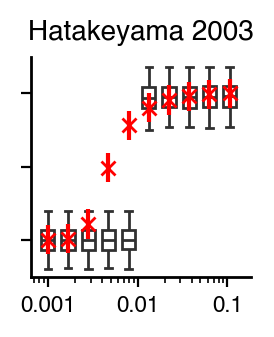

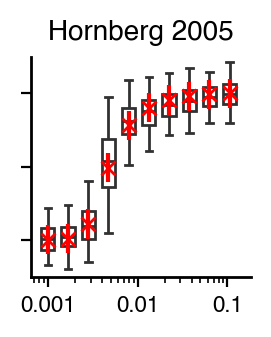

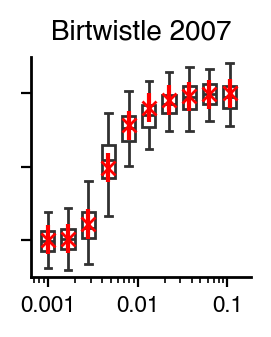

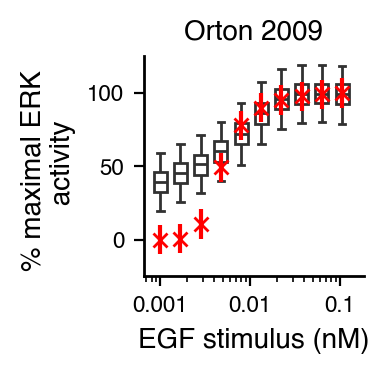

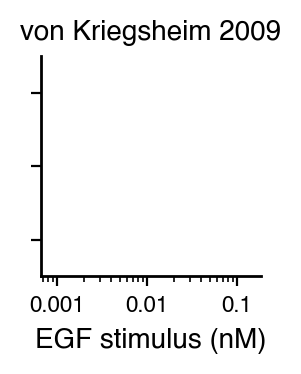

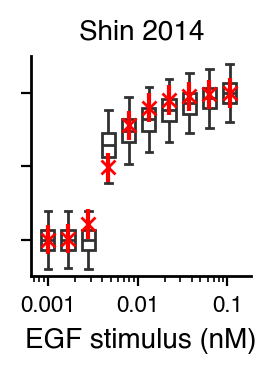

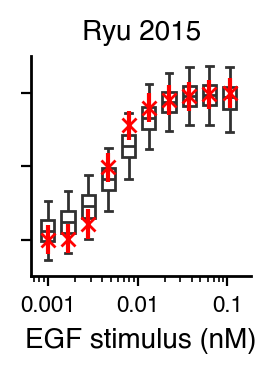

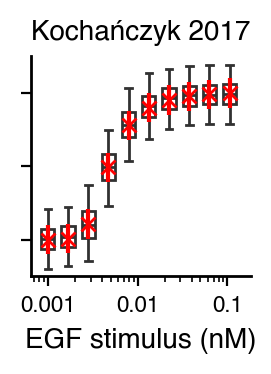

In [5]:
fig, ax = plot_stimulus_response_curve(K_2000_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_title('Kholodenko 2000', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/K_2000_posterior_predictive.pdf', transparent=True)


fig, ax = plot_stimulus_response_curve(L_2000_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Levchenko 2000', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/L_2000_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(HK_2003_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Hatakeyama 2003', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/HK_2003_posterior_predictive.pdf', transparent=True)

# TODO: Hornberg 2005
fig, ax = fig, ax = plot_stimulus_response_curve(H_2005_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
ax.set_xlim([0.0006539278817108092, 0.18412936150507658])
ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Hornberg 2005', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/H_2005_posterior_predictive.pdf', transparent=True)


fig, ax = plot_stimulus_response_curve(B_2007_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Birtwistle 2007', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/B_2007_posterior_predictive.pdf', transparent=True)


fig, ax = plot_stimulus_response_curve(O_2009_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_title('Orton 2009', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/O_2009_posterior_predictive.pdf', transparent=True)

# TODO: von Kriegsheim 2009
fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel('EGF stimulus (nM)', fontsize=10.0)
# ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_xlim([0.0006539278817108092, 0.18412936150507658])
ax.set_ylabel('')
ax.set_title('von Kriegsheim 2009', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/VK_2009_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(S_2014_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Shin 2014', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/S_2014_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(R_2015_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Ryu 2015', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/R_2015_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(K_2017_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Kochańczyk 2017', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/K_2017_posterior_predictive.pdf', transparent=True)

In [17]:
vsolve_params_traj = jax.vmap(solve_traj, in_axes=(None, None, 0, None, None, None))

def plot_trajectories(model_name, idata, n_traj, max_time, time_conversion_to_min, n_timpoints, EGF, EGF_conversion_factor, EGF_state, ERK_states, width=6.0, height=3.0, stim_type='False'):
    """ Plot trajectories for a given model """

    model = eval(model_name + '(transient={})'.format(stim_type))
 
    # get parameter names and initial conditions
    p_dict, _ = model.get_nominal_params()
    y0_dict, _ = model.get_initial_conditions()

    # convert EGF to required units
    EGF = EGF * EGF_conversion_factor

    # set EGF in the IC
    y0_dict[EGF_state] = EGF
    y0 = list(y0_dict.values())
    print(y0)

    # set up time points
    times = np.linspace(0, max_time, n_timpoints)

     # get parameter samples
    parameter_samples = get_param_subsample(idata, n_traj, p_dict)

    # get idxs of ERK states
    ERK_idxs = []
    for ERK_state in ERK_states:
        ERK_idxs.append(list(y0_dict.keys()).index(ERK_state))
    trajectories = np.array(vsolve_params_traj(diffrax.ODETerm(model), y0, parameter_samples, max_time, ERK_idxs, times))
    # plot this
    fig, ax = get_sized_fig_ax(width, height)
    for i in range(n_traj):
        ax.plot(times*time_conversion_to_min, trajectories[i,:], color='k', linewidth=0.5, alpha=0.5)

    ax.set_xlabel('Time (min)', fontsize=10.0)
    ax.set_ylabel('ERK activity', fontsize=10.0)
    ax.set_title(display_names[model_names.index(model_name)], fontsize=10.0)
    ticks = np.linspace(0, max_time*time_conversion_to_min, 5)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, fontsize=8)

    return fig, ax, trajectories, times

def get_param_subsample(idata, n_traj, p_dict):
    dat = idata.posterior.to_dict() # convert to dictionary
    free_params = list(dat['data_vars'].keys()) # figure out which params are free
    # get total number of MCMC samples
    n_samples = np.array(dat['data_vars'][free_params[0]]['data']).reshape(-1).shape[0]

    # extract samples for free params ot dict of numpy arrays
    free_param_samples = {}
    for param in free_params:
        free_param_samples[param] = np.array(dat['data_vars'][param]['data']).reshape(-1)

    # randomly select n_traj samples
    param_samples = []
    idxs = rng.choice(np.arange(n_samples), size=n_traj, replace=False)
    for i in idxs:
        tmp = []
        for param in p_dict.keys():
            if param in free_params:
                tmp.append(free_param_samples[param][i])
            else:
                tmp.append(p_dict[param])
        param_samples.append(tmp)
 
    return np.array(param_samples)

def time_to_max(trajectory, times):
    """ Get the time to max ERK activity and idx of max"""
    max_idx = np.argmax(trajectory)
    return times[max_idx], max_idx

def time_to_half_max(trajectory, times):
    """ Get the time to half max ERK activity and idx of half max"""
    max_idx = np.argmax(trajectory)
    max_val = trajectory[max_idx]
    half_max_val = max_val/2
    # get idx of first value that is greater than half max
    idx = np.where(trajectory > half_max_val)[0][0]
    return times[idx], idx

def full_half_max_width(trajectory, times):
    # get the half max time and idx
    half_max_time, half_max_idx = time_to_half_max(trajectory, times)
    
    # also get max_idx, max, and half-max
    max_idx = np.argmax(trajectory)
    max_val = trajectory[max_idx]
    half_max = max_val/2

    # get idx of values that are less than half max
    idxs = np.array(np.where(trajectory <= half_max)[0])
    idx = np.where(idxs > half_max_idx)
    if len(idx[0]) != 0:
        second_half_max_idx = idxs[idx[0][0]]
    else:
        second_half_max_idx = len(trajectory)-1

    return times[second_half_max_idx] - times[half_max_idx], second_half_max_idx

def sustained_activity_metric(trajectory, index_of_interest, max_val=None):
    # get max idx and max
    if max_val is None:
        max_idx = np.argmax(trajectory)
        max_val = trajectory[max_idx]

    return (trajectory[index_of_interest] - trajectory[0])/(max_val - trajectory[0])

def normalize_traj(trajectory, max_val=None):
    # get max idx and max
    if max_val is None:
        max_val = np.max(trajectory)

    return (trajectory - trajectory[0])/(max_val - trajectory[0])

def plot_trajectory_metric_hist(trajectory, metric_func, metric_name, width=1.0, height=1.0, color='k', fig=None, ax=None):
    """ Plot histogram of a given metric for a given trajectory """
    # apply metric function to each trajectory
    metrics = np.apply_along_axis(metric_func, 1, trajectory)

    if fig is None and ax is None:
        fig, ax = get_sized_fig_ax(width, height)

    sns.histplot(metrics, kde=True, ax=ax, color=color, stat='density')
    ax.set_ylabel('density', fontsize=10.0)
    ax.set_xlabel(metric_name, fontsize=10.0)
    return fig, ax

[0.1059253725177288, 90.0, 10.0, 0.0, 10.0, 0.0]
[0.0047315125896148, 90.0, 10.0, 0.0, 10.0, 0.0]
[0.001, 90.0, 10.0, 0.0, 10.0, 0.0]


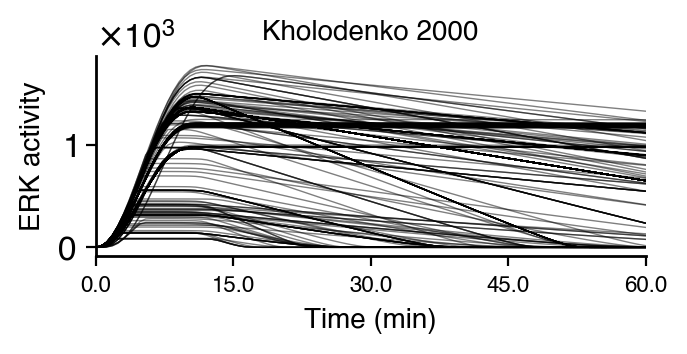

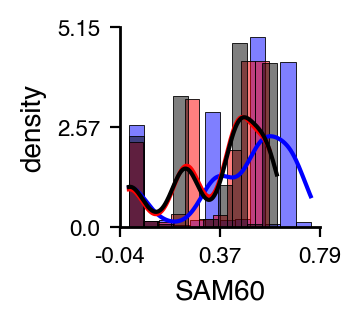

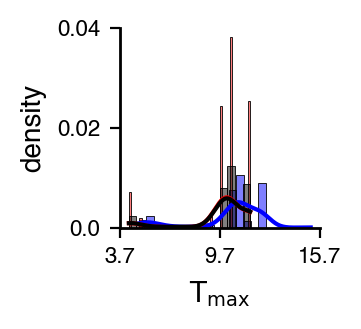

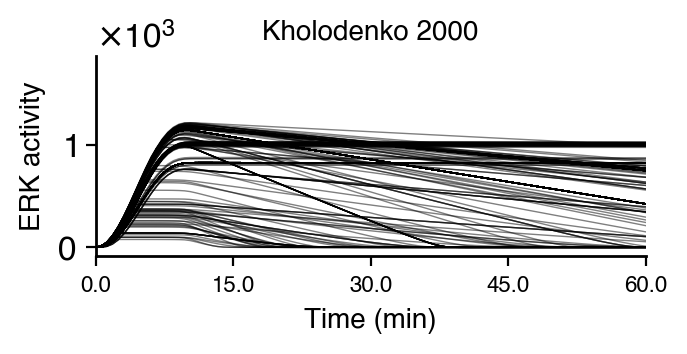

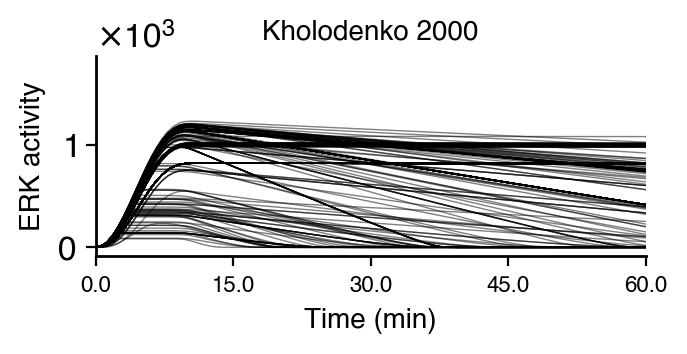

In [18]:
# EGF - 9
fig_9, ax_9, traj_shin_9, times_shin_9 = plot_trajectories('kholodenko_2000', K_2000_idata, 500, 3600, 1/60, 100, inputs[-1], 1, 'Input', ['MAPK_PP'], width=2.75, height=1.0)
ax_9.set_xlim([0,60])
ylim = ax_9.get_ylim()
ax_9.set_ylim(ylim)

max_val = np.max(traj_shin_9)
metric_func = lambda traj: sustained_activity_metric(traj, -1, max_val)
fig_SAM, ax_SAM = plot_trajectory_metric_hist(traj_shin_9, metric_func, 'SAM60', width=1.0, height=1.0, color='b')

metric_func = lambda traj: time_to_max(traj, times_shin_9)[0]
fig_Tmax, ax_Tmax =plot_trajectory_metric_hist(traj_shin_9, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, color='b')

# EGF - 3
fig_3, ax_3, traj_shin_3, times_shin_3 = plot_trajectories('kholodenko_2000', K_2000_idata, 500, 3600, 1/60, 100, inputs[3], 1, 'Input', ['MAPK_PP'], width=2.75, height=1.0)
ax_3.set_xlim([0,60])
ax_3.set_ylim(ylim)

metric_func = lambda traj: sustained_activity_metric(traj, -1, max_val)
plot_trajectory_metric_hist(traj_shin_3, metric_func, 'SAM60', width=1.0, height=1.0, ax=ax_SAM, fig=fig_SAM, color='r')

metric_func = lambda traj: time_to_max(traj, times_shin_3)[0]
plot_trajectory_metric_hist(traj_shin_3, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, ax=ax_Tmax, fig=fig_Tmax, color='r')


# EGF - zero
fig_0, ax_0, traj_shin_0, times_shin_0 = plot_trajectories('kholodenko_2000', K_2000_idata, 500, 3600, 1/60, 100, inputs[0], 1, 'Input', ['MAPK_PP'], width=2.75, height=1.0)
ax_0.set_xlim([0,60])
ax_0.set_ylim(ylim)

metric_func = lambda traj: sustained_activity_metric(traj, -1, max_val)
plot_trajectory_metric_hist(traj_shin_0, metric_func, 'SAM60', width=1.0, height=1.0, ax=ax_SAM, fig=fig_SAM, color='k')

metric_func = lambda traj: time_to_max(traj, times_shin_0)[0]
plot_trajectory_metric_hist(traj_shin_0, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, ax=ax_Tmax, fig=fig_Tmax, color='k')

xlim = ax_SAM.get_xlim()
ticks = np.linspace(xlim[0], xlim[1], 3)
ax_SAM.set_xticks(ticks)
ax_SAM.set_xticklabels(np.around(ticks, decimals=2), fontsize=8)
ylim = ax_SAM.get_ylim()
ticks = np.linspace(ylim[0], ylim[1], 3)
ax_SAM.set_yticks(ticks)
ax_SAM.set_yticklabels(np.around(ticks, decimals=2), fontsize=8)

xlim = ax_Tmax.get_xlim()
ticks = np.linspace(xlim[0], xlim[1], 3)
ax_Tmax.set_xticks(ticks)
ax_Tmax.set_xticklabels(np.around(ticks/60, decimals=2), fontsize=8)
ylim = ax_Tmax.get_ylim()
ticks = np.linspace(ylim[0], ylim[1], 3)
ax_Tmax.set_yticks(ticks)
ax_Tmax.set_yticklabels(np.around(ticks, decimals=2), fontsize=8)

fig_9.savefig('../../../results/MAPK/param_est/K_2000_EGF{}.pdf'.format(inputs[-1]), transparent=True)
fig_3.savefig('../../../results/MAPK/param_est/K_2000_EGF{}.pdf'.format(inputs[3]), transparent=True)
fig_0.savefig('../../../results/MAPK/param_est/K_2000_EGF{}.pdf'.format(inputs[0]), transparent=True)

fig_SAM.savefig('../../../results/MAPK/param_est/K_2000_SAM60.pdf', transparent=True)
fig_Tmax.savefig('../../../results/MAPK/param_est/K_2000_Tmax.pdf', transparent=True)

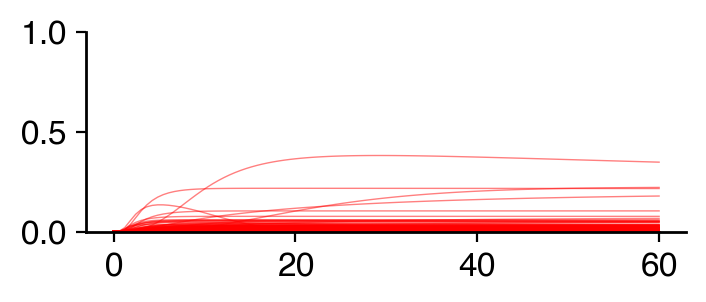

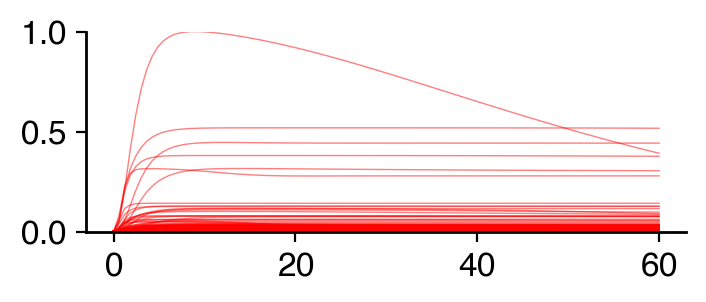

In [16]:
max_val = np.max(traj_shin_9)

fig, ax = get_sized_fig_ax(3.0, 1.0)
ax.plot(times_shin_3, np.apply_along_axis(normalize_traj, 1, traj_shin_0, max_val).T, color='r', linewidth=0.5, alpha=0.5)
ax.set_ylim([0.0, 1.0])
plt.show()

fig, ax = get_sized_fig_ax(3.0, 1.0)
ax.plot(times_shin_3, np.apply_along_axis(normalize_traj, 1, traj_shin_9, max_val).T, color='r', linewidth=0.5, alpha=0.5)
ax.set_ylim([0.0, 1.0])
plt.show()

In [42]:
# EGF - 9
fig_9, ax_9, traj_shin_9, times_shin_9 = plot_trajectories('levchenko_2000', L_2000_idata, 500, 3600, 1/60, 100, inputs[-1], 0.001, 'RAFact', ['MAPKstarstar'], width=2.75, height=1.0)
ax_9.set_xlim([0,60])
ylim = ax_9.get_ylim()
ax_9.set_ylim(ylim)


metric_func = lambda traj: sustained_activity_metric(traj, -1)
fig_SAM, ax_SAM = plot_trajectory_metric_hist(traj_shin_9, metric_func, 'SAM60', width=1.0, height=1.0, color='b')

metric_func = lambda traj: time_to_max(traj, times_shin_9)[0]
fig_Tmax, ax_Tmax =plot_trajectory_metric_hist(traj_shin_9, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, color='b')

# EGF - 3
fig_3, ax_3, traj_shin_3, times_shin_3 = plot_trajectories('levchenko_2000', L_2000_idata, 500, 3600, 1/60, 100, inputs[3], 0.001, 'RAFact', ['MAPKstarstar'],width=2.75, height=1.0)
ax_3.set_xlim([0,60])
ax_3.set_ylim(ylim)

metric_func = lambda traj: sustained_activity_metric(traj, -1)
plot_trajectory_metric_hist(traj_shin_3, metric_func, 'SAM60', width=1.0, height=1.0, ax=ax_SAM, fig=fig_SAM, color='r')

metric_func = lambda traj: time_to_max(traj, times_shin_3)[0]
plot_trajectory_metric_hist(traj_shin_3, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, ax=ax_Tmax, fig=fig_Tmax, color='r')


# EGF - zero
fig_0, ax_0, traj_shin_0, times_shin_0 = plot_trajectories('levchenko_2000', L_2000_idata, 500, 3600, 1/60, 100, inputs[0], 0.001, 'RAFact', ['MAPKstarstar'], width=2.75, height=1.0)
ax_0.set_xlim([0,60])
ax_0.set_ylim(ylim)

metric_func = lambda traj: sustained_activity_metric(traj, -1)
plot_trajectory_metric_hist(traj_shin_0, metric_func, 'SAM60', width=1.0, height=1.0, ax=ax_SAM, fig=fig_SAM, color='k')

metric_func = lambda traj: time_to_max(traj, times_shin_0)[0]
plot_trajectory_metric_hist(traj_shin_0, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, ax=ax_Tmax, fig=fig_Tmax, color='k')

xlim = ax_SAM.get_xlim()
ticks = np.linspace(xlim[0], xlim[1], 3)
ax_SAM.set_xticks(ticks)
ax_SAM.set_xticklabels(np.around(ticks, decimals=2), fontsize=8)
ylim = ax_SAM.get_ylim()
ticks = np.linspace(ylim[0], ylim[1], 3)
ax_SAM.set_yticks(ticks)
ax_SAM.set_yticklabels(np.around(ticks, decimals=2), fontsize=8)

xlim = ax_Tmax.get_xlim()
ticks = np.linspace(xlim[0], xlim[1], 3)
ax_Tmax.set_xticks(ticks)
ax_Tmax.set_xticklabels(np.around(ticks/60, decimals=2), fontsize=8)
ylim = ax_Tmax.get_ylim()
ticks = np.linspace(ylim[0], ylim[1], 3)
ax_Tmax.set_yticks(ticks)
ax_Tmax.set_yticklabels(np.around(ticks, decimals=2), fontsize=8)

fig_9.savefig('../../../results/MAPK/param_est/L_2000_EGF{}.pdf'.format(inputs[-1]), transparent=True)
fig_3.savefig('../../../results/MAPK/param_est/L_2000_EGF{}.pdf'.format(inputs[3]), transparent=True)
fig_0.savefig('../../../results/MAPK/param_est/L_2000_EGF{}.pdf'.format(inputs[0]), transparent=True)

fig_SAM.savefig('../../../results/MAPK/param_est/L_2000_SAM60.pdf', transparent=True)
fig_Tmax.savefig('../../../results/MAPK/param_est/L_2000_Tmax.pdf', transparent=True)

[0.0001059253725177288, 0.3, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


KeyboardInterrupt: 

In [ ]:
np.apply_along_axis(normalize_traj, 1, traj_shin_3).shape

fig, ax = get_sized_fig_ax(3.0, 1.0)
ax.plot(times_shin_3, np.apply_along_axis(normalize_traj, 1, traj_shin_0).T, color='r', linewidth=0.5, alpha=0.5)
plt.show()

fig, ax = get_sized_fig_ax(3.0, 1.0)
ax.plot(times_shin_3, np.apply_along_axis(normalize_traj, 1, traj_shin_9).T, color='r', linewidth=0.5, alpha=0.5)
plt.show()

[80.0, 1000.0, 10.0, 0.1059253725177288, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 120.0, 0.0, 0.0, 100.0, 0.0, 0.0, 800.0, 0.0, 10.0, 0.0, 0.0, 120.0, 1000.0, 0.0, 0.0]
[80.0, 1000.0, 10.0, 0.0047315125896148, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 120.0, 0.0, 0.0, 100.0, 0.0, 0.0, 800.0, 0.0, 10.0, 0.0, 0.0, 120.0, 1000.0, 0.0, 0.0]
[80.0, 1000.0, 10.0, 0.1059253725177288, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 120.0, 0.0, 0.0, 100.0, 0.0, 0.0, 800.0, 0.0, 10.0, 0.0, 0.0, 120.0, 1000.0, 0.0, 0.0]


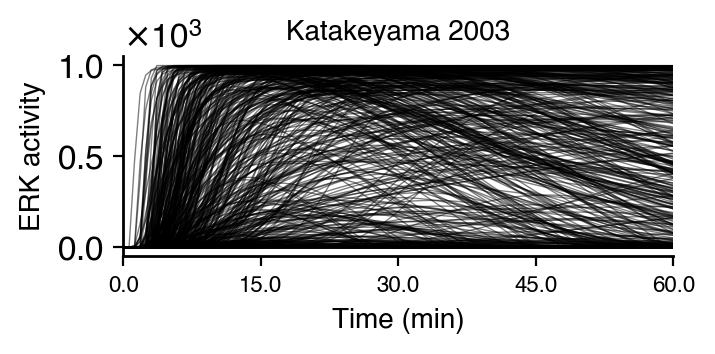

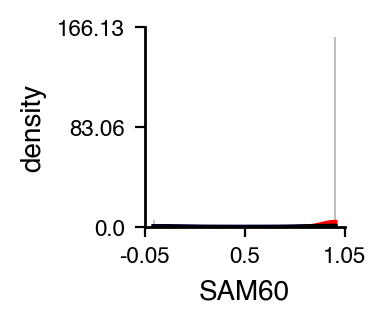

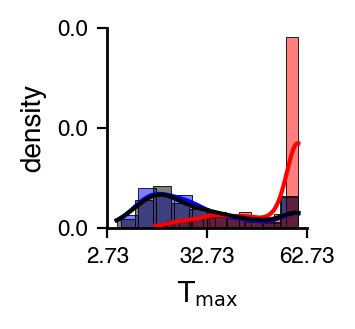

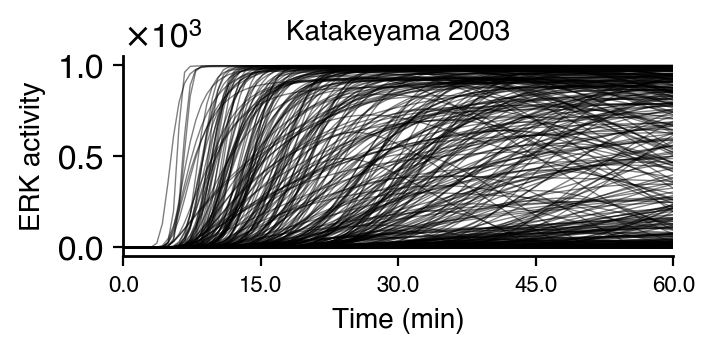

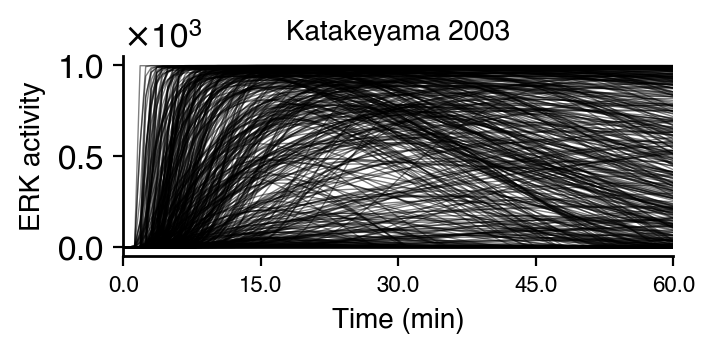

In [ ]:
# EGF - 9
fig_9, ax_9, traj_shin_9, times_shin_9 = plot_trajectories('hatakeyama_2003', HK_2003_idata, 500, 3600, 1/60, 100, inputs[-1], 1, 'HRG', ['ERKPP'], width=2.75, height=1.0)
ax_9.set_xlim([0,60])
ylim = ax_9.get_ylim()
ax_9.set_ylim(ylim)


metric_func = lambda traj: sustained_activity_metric(traj, -1)
fig_SAM, ax_SAM = plot_trajectory_metric_hist(traj_shin_9, metric_func, 'SAM60', width=1.0, height=1.0, color='b')

metric_func = lambda traj: time_to_max(traj, times_shin_9)[0]
fig_Tmax, ax_Tmax =plot_trajectory_metric_hist(traj_shin_9, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, color='b')

# EGF - 3
fig_3, ax_3, traj_shin_3, times_shin_3 = plot_trajectories('hatakeyama_2003', HK_2003_idata, 500, 3600, 1/60, 100, inputs[3], 1, 'HRG', ['ERKPP'], width=2.75, height=1.0)
ax_3.set_xlim([0,60])
ax_3.set_ylim(ylim)

metric_func = lambda traj: sustained_activity_metric(traj, -1)
plot_trajectory_metric_hist(traj_shin_3, metric_func, 'SAM60', width=1.0, height=1.0, ax=ax_SAM, fig=fig_SAM, color='r')

metric_func = lambda traj: time_to_max(traj, times_shin_3)[0]
plot_trajectory_metric_hist(traj_shin_3, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, ax=ax_Tmax, fig=fig_Tmax, color='r')


# EGF - zero
fig_0, ax_0, traj_shin_0, times_shin_0 = plot_trajectories('hatakeyama_2003', HK_2003_idata, 500, 3600, 1/60, 100, inputs[-1], 1, 'HRG', ['ERKPP'], width=2.75, height=1.0)
ax_0.set_xlim([0,60])
ax_0.set_ylim(ylim)

metric_func = lambda traj: sustained_activity_metric(traj, -1)
plot_trajectory_metric_hist(traj_shin_0, metric_func, 'SAM60', width=1.0, height=1.0, ax=ax_SAM, fig=fig_SAM, color='k')

metric_func = lambda traj: time_to_max(traj, times_shin_0)[0]
plot_trajectory_metric_hist(traj_shin_0, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, ax=ax_Tmax, fig=fig_Tmax, color='k')

xlim = ax_SAM.get_xlim()
ticks = np.linspace(xlim[0], xlim[1], 3)
ax_SAM.set_xticks(ticks)
ax_SAM.set_xticklabels(np.around(ticks, decimals=2), fontsize=8)
ylim = ax_SAM.get_ylim()
ticks = np.linspace(ylim[0], ylim[1], 3)
ax_SAM.set_yticks(ticks)
ax_SAM.set_yticklabels(np.around(ticks, decimals=2), fontsize=8)

xlim = ax_Tmax.get_xlim()
ticks = np.linspace(xlim[0], xlim[1], 3)
ax_Tmax.set_xticks(ticks)
ax_Tmax.set_xticklabels(np.around(ticks/60, decimals=2), fontsize=8)
ylim = ax_Tmax.get_ylim()
ticks = np.linspace(ylim[0], ylim[1], 3)
ax_Tmax.set_yticks(ticks)
ax_Tmax.set_yticklabels(np.around(ticks, decimals=2), fontsize=8)

fig_9.savefig('../../../results/MAPK/param_est/HK_2003_EGF{}.pdf'.format(inputs[-1]), transparent=True)
fig_3.savefig('../../../results/MAPK/param_est/HK_2003_EGF{}.pdf'.format(inputs[3]), transparent=True)
fig_0.savefig('../../../results/MAPK/param_est/HK_2003_EGF{}.pdf'.format(inputs[0]), transparent=True)

fig_SAM.savefig('../../../results/MAPK/param_est/HK_2003_SAM60.pdf', transparent=True)
fig_Tmax.savefig('../../../results/MAPK/param_est/HK_2003_Tmax.pdf', transparent=True)

[63789.74228539153, 120000.0, 0.0, 120000.0, 0.0, 120000.0, 0.0, 0.0, 120000.0, 0.0, 120000.0, 0.0, 120000.0, 0.0, 600000.0, 0.0, 600000.0, 0.0, 120000.0, 0.0, 120000.0, 0.0, 120000.0, 0.0, 80000.0, 0.0]
[2849.383122642287, 120000.0, 0.0, 120000.0, 0.0, 120000.0, 0.0, 0.0, 120000.0, 0.0, 120000.0, 0.0, 120000.0, 0.0, 600000.0, 0.0, 600000.0, 0.0, 120000.0, 0.0, 120000.0, 0.0, 120000.0, 0.0, 80000.0, 0.0]
[602.214, 120000.0, 0.0, 120000.0, 0.0, 120000.0, 0.0, 0.0, 120000.0, 0.0, 120000.0, 0.0, 120000.0, 0.0, 600000.0, 0.0, 600000.0, 0.0, 120000.0, 0.0, 120000.0, 0.0, 120000.0, 0.0, 80000.0, 0.0]


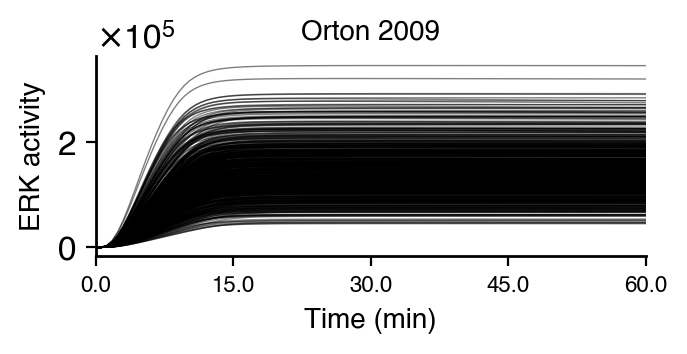

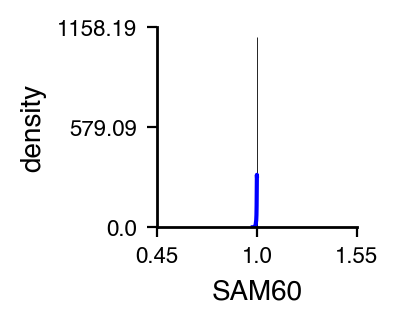

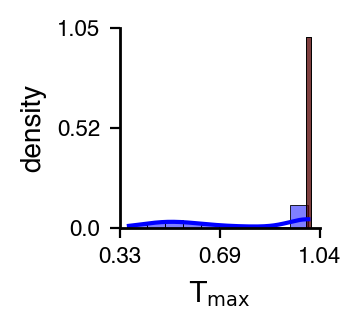

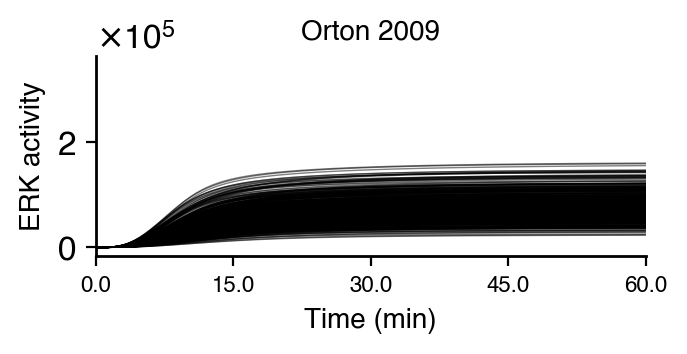

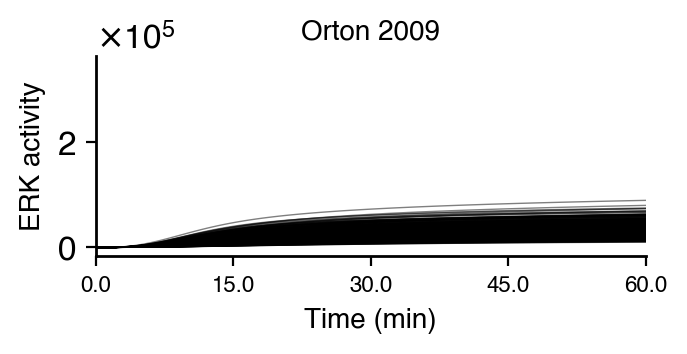

In [ ]:
# EGF - 9
fig_9, ax_9, traj_shin_9, times_shin_9 = plot_trajectories('orton_2009', O_2009_idata, 500, 60, 1, 100, inputs[-1], 602214, 'EGF', ['ErkActive'],  width=2.75, height=1.0)
ax_9.set_xlim([0,60])
ylim = ax_9.get_ylim()
ax_9.set_ylim(ylim)


metric_func = lambda traj: sustained_activity_metric(traj, -1)
fig_SAM, ax_SAM = plot_trajectory_metric_hist(traj_shin_9, metric_func, 'SAM60', width=1.0, height=1.0, color='b')

metric_func = lambda traj: time_to_max(traj, times_shin_9)[0]
fig_Tmax, ax_Tmax =plot_trajectory_metric_hist(traj_shin_9, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, color='b')

# EGF - 3
fig_3, ax_3, traj_shin_3, times_shin_3 = plot_trajectories('orton_2009', O_2009_idata, 500, 60, 1, 100, inputs[3], 602214, 'EGF', ['ErkActive'], width=2.75, height=1.0)
ax_3.set_xlim([0,60])
ax_3.set_ylim(ylim)

metric_func = lambda traj: sustained_activity_metric(traj, -1)
plot_trajectory_metric_hist(traj_shin_3, metric_func, 'SAM60', width=1.0, height=1.0, ax=ax_SAM, fig=fig_SAM, color='r')

metric_func = lambda traj: time_to_max(traj, times_shin_3)[0]
plot_trajectory_metric_hist(traj_shin_3, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, ax=ax_Tmax, fig=fig_Tmax, color='r')


# EGF - zero
fig_0, ax_0, traj_shin_0, times_shin_0 = plot_trajectories('orton_2009', O_2009_idata, 500, 60, 1, 100, inputs[0], 602214, 'EGF', ['ErkActive'], width=2.75, height=1.0)
ax_0.set_xlim([0,60])
ax_0.set_ylim(ylim)

metric_func = lambda traj: sustained_activity_metric(traj, -1)
plot_trajectory_metric_hist(traj_shin_0, metric_func, 'SAM60', width=1.0, height=1.0, ax=ax_SAM, fig=fig_SAM, color='k')

metric_func = lambda traj: time_to_max(traj, times_shin_0)[0]
plot_trajectory_metric_hist(traj_shin_0, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, ax=ax_Tmax, fig=fig_Tmax, color='k')

xlim = ax_SAM.get_xlim()
ticks = np.linspace(xlim[0], xlim[1], 3)
ax_SAM.set_xticks(ticks)
ax_SAM.set_xticklabels(np.around(ticks, decimals=2), fontsize=8)
ylim = ax_SAM.get_ylim()
ticks = np.linspace(ylim[0], ylim[1], 3)
ax_SAM.set_yticks(ticks)
ax_SAM.set_yticklabels(np.around(ticks, decimals=2), fontsize=8)

xlim = ax_Tmax.get_xlim()
ticks = np.linspace(xlim[0], xlim[1], 3)
ax_Tmax.set_xticks(ticks)
ax_Tmax.set_xticklabels(np.around(ticks/60, decimals=2), fontsize=8)
ylim = ax_Tmax.get_ylim()
ticks = np.linspace(ylim[0], ylim[1], 3)
ax_Tmax.set_yticks(ticks)
ax_Tmax.set_yticklabels(np.around(ticks, decimals=2), fontsize=8)

fig_9.savefig('../../../results/MAPK/param_est/O_2009_EGF{}.pdf'.format(inputs[-1]), transparent=True)
fig_3.savefig('../../../results/MAPK/param_est/O_2009_EGF{}.pdf'.format(inputs[3]), transparent=True)
fig_0.savefig('../../../results/MAPK/param_est/O_2009_EGF{}.pdf'.format(inputs[0]), transparent=True)

fig_SAM.savefig('../../../results/MAPK/param_est/O_2009_SAM60.pdf', transparent=True)
fig_Tmax.savefig('../../../results/MAPK/param_est/O_2009_Tmax.pdf', transparent=True)

[0.0001059253725177288, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[4.7315125896148e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


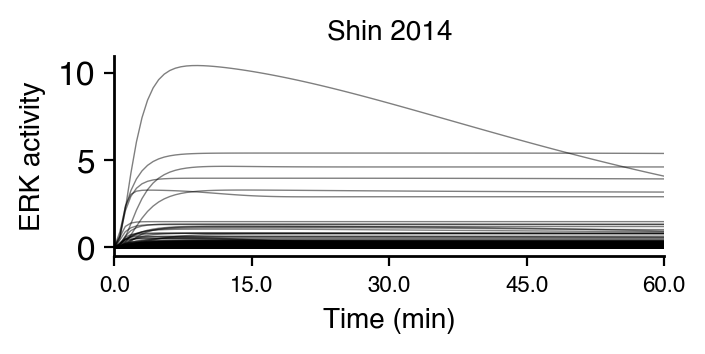

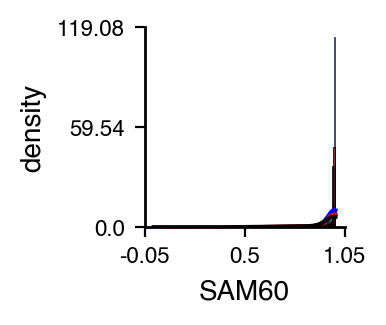

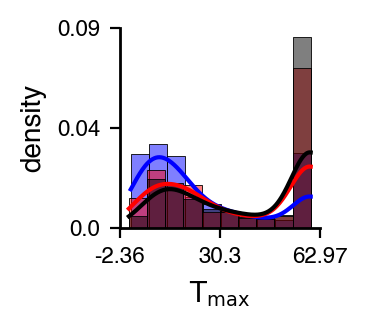

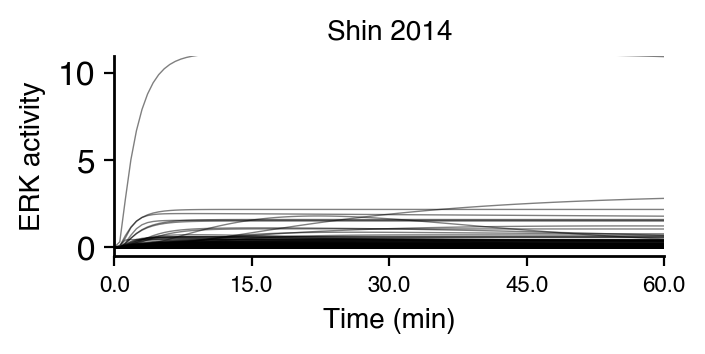

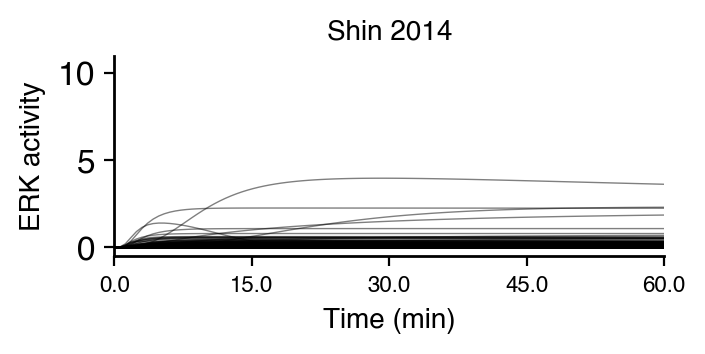

In [11]:
# EGF - 9
fig_9, ax_9, traj_shin_9, times_shin_9 = plot_trajectories('shin_2014', S_2014_idata, 500, 60, 1, 100, inputs[-1], 0.001, 'EGF', ['pp_ERK'], width=2.75, height=1.0)
ax_9.set_xlim([0,60])
ylim = ax_9.get_ylim()
ax_9.set_ylim(ylim)


metric_func = lambda traj: sustained_activity_metric(traj, -1)
fig_SAM, ax_SAM = plot_trajectory_metric_hist(traj_shin_9, metric_func, 'SAM60', width=1.0, height=1.0, color='b')

metric_func = lambda traj: time_to_max(traj, times_shin_9)[0]
fig_Tmax, ax_Tmax =plot_trajectory_metric_hist(traj_shin_9, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, color='b')

# EGF - 3
fig_3, ax_3, traj_shin_3, times_shin_3 = plot_trajectories('shin_2014', S_2014_idata, 500, 60, 1, 100, inputs[3], 0.001, 'EGF', ['pp_ERK'],  width=2.75, height=1.0)
ax_3.set_xlim([0,60])
ax_3.set_ylim(ylim)

metric_func = lambda traj: sustained_activity_metric(traj, -1)
plot_trajectory_metric_hist(traj_shin_3, metric_func, 'SAM60', width=1.0, height=1.0, ax=ax_SAM, fig=fig_SAM, color='r')

metric_func = lambda traj: time_to_max(traj, times_shin_3)[0]
plot_trajectory_metric_hist(traj_shin_3, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, ax=ax_Tmax, fig=fig_Tmax, color='r')


# EGF - zero
fig_0, ax_0, traj_shin_0, times_shin_0 = plot_trajectories('shin_2014', S_2014_idata, 500, 60, 1, 100, inputs[0], 0.001, 'EGF', ['pp_ERK'],  width=2.75, height=1.0)
ax_0.set_xlim([0,60])
ax_0.set_ylim(ylim)

metric_func = lambda traj: sustained_activity_metric(traj, -1)
plot_trajectory_metric_hist(traj_shin_0, metric_func, 'SAM60', width=1.0, height=1.0, ax=ax_SAM, fig=fig_SAM, color='k')

metric_func = lambda traj: time_to_max(traj, times_shin_0)[0]
plot_trajectory_metric_hist(traj_shin_0, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, ax=ax_Tmax, fig=fig_Tmax, color='k')

xlim = ax_SAM.get_xlim()
ticks = np.linspace(xlim[0], xlim[1], 3)
ax_SAM.set_xticks(ticks)
ax_SAM.set_xticklabels(np.around(ticks, decimals=2), fontsize=8)
ylim = ax_SAM.get_ylim()
ticks = np.linspace(ylim[0], ylim[1], 3)
ax_SAM.set_yticks(ticks)
ax_SAM.set_yticklabels(np.around(ticks, decimals=2), fontsize=8)

xlim = ax_Tmax.get_xlim()
ticks = np.linspace(xlim[0], xlim[1], 3)
ax_Tmax.set_xticks(ticks)
ax_Tmax.set_xticklabels(np.around(ticks, decimals=2), fontsize=8)
ylim = ax_Tmax.get_ylim()
ticks = np.linspace(ylim[0], ylim[1], 3)
ax_Tmax.set_yticks(ticks)
ax_Tmax.set_yticklabels(np.around(ticks, decimals=2), fontsize=8)

fig_9.savefig('../../../results/MAPK/param_est/S_2014_EGF{}.pdf'.format(inputs[-1]), transparent=True)
fig_3.savefig('../../../results/MAPK/param_est/S_2014_EGF{}.pdf'.format(inputs[3]), transparent=True)
fig_0.savefig('../../../results/MAPK/param_est/S_2014_EGF{}.pdf'.format(inputs[0]), transparent=True)

fig_SAM.savefig('../../../results/MAPK/param_est/S_2014_SAM60.pdf', transparent=True)
fig_Tmax.savefig('../../../results/MAPK/param_est/S_2014_Tmax.pdf', transparent=True)

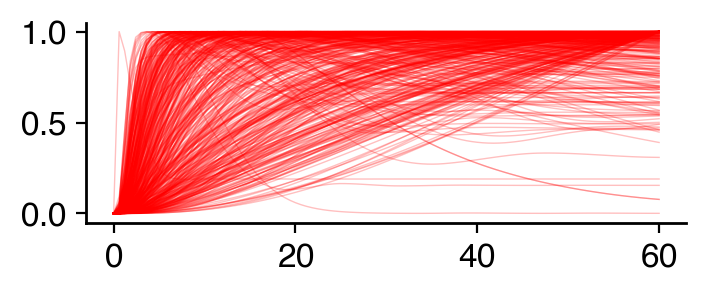

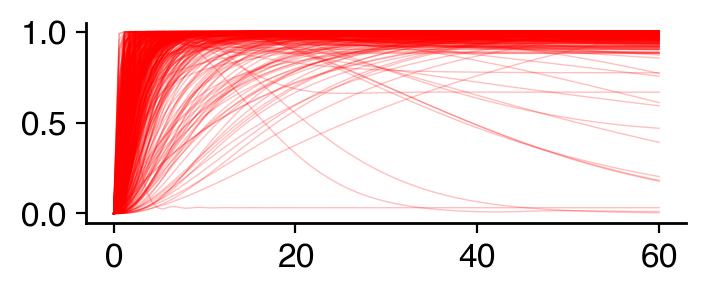

In [13]:
np.apply_along_axis(normalize_traj, 1, traj_shin_3).shape

fig, ax = get_sized_fig_ax(3.0, 1.0)
ax.plot(times_shin_3, np.apply_along_axis(normalize_traj, 1, traj_shin_0).T, color='r', linewidth=0.5, alpha=0.25)
plt.show()

fig, ax = get_sized_fig_ax(3.0, 1.0)
ax.plot(times_shin_3, np.apply_along_axis(normalize_traj, 1, traj_shin_9).T, color='r', linewidth=0.5, alpha=0.25)
plt.show()

[0.006048, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
[0.006048, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
[0.006048, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]


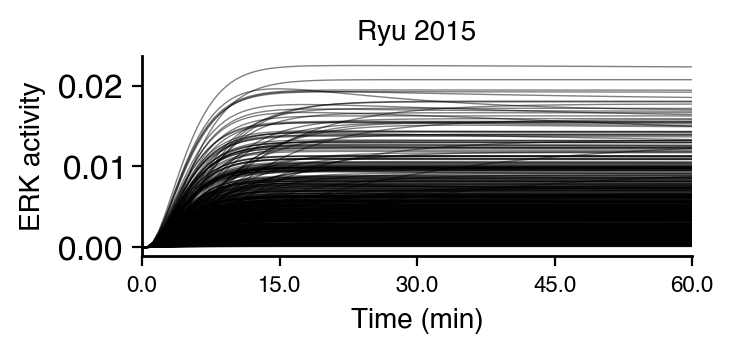

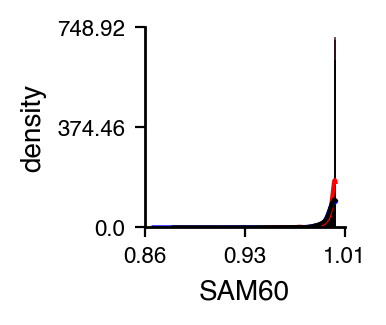

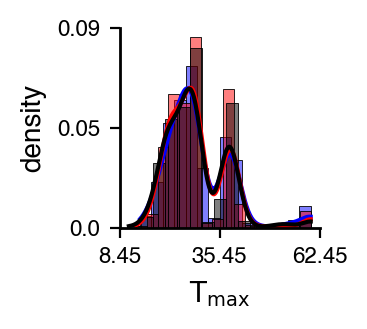

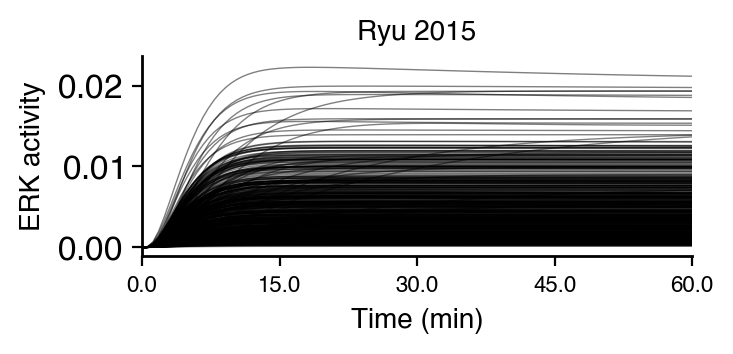

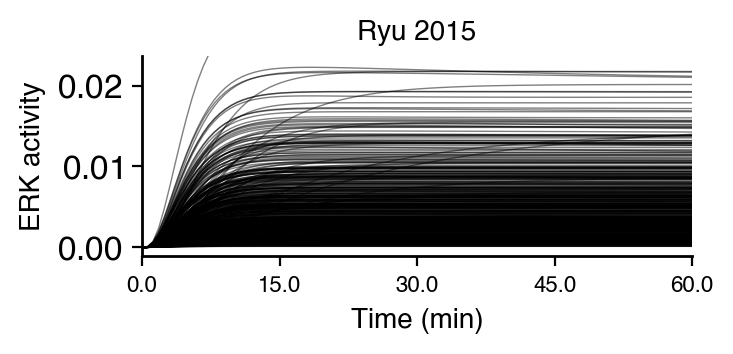

In [ ]:
# EGF - 9
fig_9, ax_9, traj_shin_9, times_shin_9 = plot_trajectories('ryu_2015', R_2015_idata, 500, 60, 1, 100, inputs[0], 6.048, 'EGF', ['ERK_star'], width=2.75, height=1.0)
ax_9.set_xlim([0,60])
ylim = ax_9.get_ylim()
ax_9.set_ylim(ylim)


metric_func = lambda traj: sustained_activity_metric(traj, -1)
fig_SAM, ax_SAM = plot_trajectory_metric_hist(traj_shin_9, metric_func, 'SAM60', width=1.0, height=1.0, color='b')

metric_func = lambda traj: time_to_max(traj, times_shin_9)[0]
fig_Tmax, ax_Tmax =plot_trajectory_metric_hist(traj_shin_9, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, color='b')

# EGF - 3
fig_3, ax_3, traj_shin_3, times_shin_3 = plot_trajectories('ryu_2015', R_2015_idata, 500, 60, 1, 100, inputs[0], 6.048, 'EGF', ['ERK_star'], width=2.75, height=1.0)
ax_3.set_xlim([0,60])
ax_3.set_ylim(ylim)

metric_func = lambda traj: sustained_activity_metric(traj, -1)
plot_trajectory_metric_hist(traj_shin_3, metric_func, 'SAM60', width=1.0, height=1.0, ax=ax_SAM, fig=fig_SAM, color='r')

metric_func = lambda traj: time_to_max(traj, times_shin_3)[0]
plot_trajectory_metric_hist(traj_shin_3, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, ax=ax_Tmax, fig=fig_Tmax, color='r')


# EGF - zero
fig_0, ax_0, traj_shin_0, times_shin_0 = plot_trajectories('ryu_2015', R_2015_idata, 500, 60, 1, 100, inputs[0], 6.048, 'EGF', ['ERK_star'], width=2.75, height=1.0)
ax_0.set_xlim([0,60])
ax_0.set_ylim(ylim)

metric_func = lambda traj: sustained_activity_metric(traj, -1)
plot_trajectory_metric_hist(traj_shin_0, metric_func, 'SAM60', width=1.0, height=1.0, ax=ax_SAM, fig=fig_SAM, color='k')

metric_func = lambda traj: time_to_max(traj, times_shin_0)[0]
plot_trajectory_metric_hist(traj_shin_0, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, ax=ax_Tmax, fig=fig_Tmax, color='k')

xlim = ax_SAM.get_xlim()
ticks = np.linspace(xlim[0], xlim[1], 3)
ax_SAM.set_xticks(ticks)
ax_SAM.set_xticklabels(np.around(ticks, decimals=2), fontsize=8)
ylim = ax_SAM.get_ylim()
ticks = np.linspace(ylim[0], ylim[1], 3)
ax_SAM.set_yticks(ticks)
ax_SAM.set_yticklabels(np.around(ticks, decimals=2), fontsize=8)

xlim = ax_Tmax.get_xlim()
ticks = np.linspace(xlim[0], xlim[1], 3)
ax_Tmax.set_xticks(ticks)
ax_Tmax.set_xticklabels(np.around(ticks, decimals=2), fontsize=8)
ylim = ax_Tmax.get_ylim()
ticks = np.linspace(ylim[0], ylim[1], 3)
ax_Tmax.set_yticks(ticks)
ax_Tmax.set_yticklabels(np.around(ticks, decimals=2), fontsize=8)

fig_9.savefig('../../../results/MAPK/param_est/R_2015_EGF{}.pdf'.format(inputs[-1]), transparent=True)
fig_3.savefig('../../../results/MAPK/param_est/R_2015_EGF{}.pdf'.format(inputs[3]), transparent=True)
fig_0.savefig('../../../results/MAPK/param_est/R_2015_EGF{}.pdf'.format(inputs[0]), transparent=True)

fig_SAM.savefig('../../../results/MAPK/param_est/R_2015_SAM60.pdf', transparent=True)
fig_Tmax.savefig('../../../results/MAPK/param_est/R_2015_Tmax.pdf', transparent=True)

[640.6366529872238, 300000.0, 60000.0, 0.0, 100000.0, 6000.0, 500000.0, 200000.0, 3000000.0, 1000000.0, 1000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[28.61618814199031, 300000.0, 60000.0, 0.0, 100000.0, 6000.0, 500000.0, 200000.0, 3000000.0, 1000000.0, 1000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[6.048, 300000.0, 60000.0, 0.0, 100000.0, 6000.0, 500000.0, 200000.0, 3000000.0, 1000000.0, 1000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


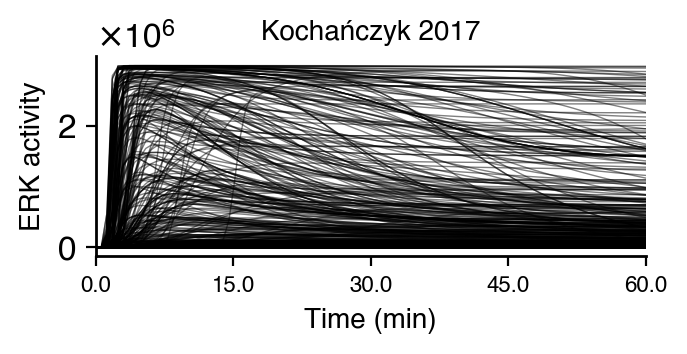

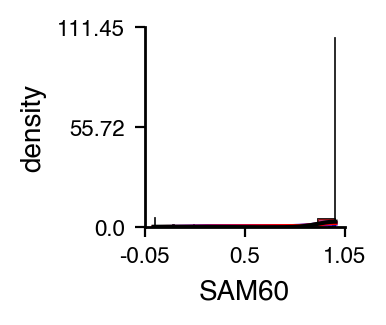

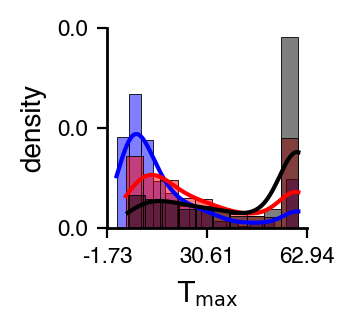

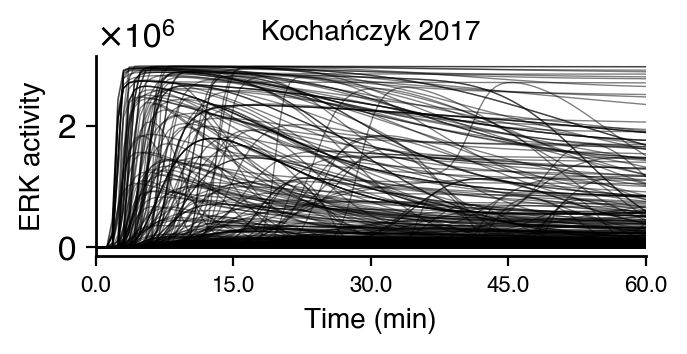

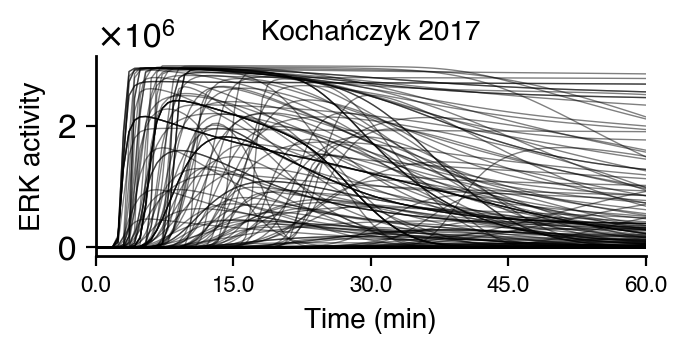

In [ ]:
# EGF - 9
fig_9, ax_9, traj_shin_9, times_shin_9 = plot_trajectories('kochanczyk_2017', K_2017_idata, 500, 3600, 1/60, 100, inputs[-1], 6048, 'EGF', ['ERKSPP'],  width=2.75, height=1.0)
ax_9.set_xlim([0,60])
ylim = ax_9.get_ylim()
ax_9.set_ylim(ylim)


metric_func = lambda traj: sustained_activity_metric(traj, -1)
fig_SAM, ax_SAM = plot_trajectory_metric_hist(traj_shin_9, metric_func, 'SAM60', width=1.0, height=1.0, color='b')

metric_func = lambda traj: time_to_max(traj, times_shin_9)[0]
fig_Tmax, ax_Tmax =plot_trajectory_metric_hist(traj_shin_9, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, color='b')

# EGF - 3
fig_3, ax_3, traj_shin_3, times_shin_3 = plot_trajectories('kochanczyk_2017', K_2017_idata, 500, 3600, 1/60, 100, inputs[3], 6048, 'EGF', ['ERKSPP'],  width=2.75, height=1.0)
ax_3.set_xlim([0,60])
ax_3.set_ylim(ylim)

metric_func = lambda traj: sustained_activity_metric(traj, -1)
plot_trajectory_metric_hist(traj_shin_3, metric_func, 'SAM60', width=1.0, height=1.0, ax=ax_SAM, fig=fig_SAM, color='r')

metric_func = lambda traj: time_to_max(traj, times_shin_3)[0]
plot_trajectory_metric_hist(traj_shin_3, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, ax=ax_Tmax, fig=fig_Tmax, color='r')


# EGF - zero
fig_0, ax_0, traj_shin_0, times_shin_0 = plot_trajectories('kochanczyk_2017', K_2017_idata, 500, 3600, 1/60, 100, inputs[0], 6048, 'EGF', ['ERKSPP'],  width=2.75, height=1.0)
ax_0.set_xlim([0,60])
ax_0.set_ylim(ylim)

metric_func = lambda traj: sustained_activity_metric(traj, -1)
plot_trajectory_metric_hist(traj_shin_0, metric_func, 'SAM60', width=1.0, height=1.0, ax=ax_SAM, fig=fig_SAM, color='k')

metric_func = lambda traj: time_to_max(traj, times_shin_0)[0]
plot_trajectory_metric_hist(traj_shin_0, metric_func, r'$T_{\rm max}$', width=1.0, height=1.0, ax=ax_Tmax, fig=fig_Tmax, color='k')

xlim = ax_SAM.get_xlim()
ticks = np.linspace(xlim[0], xlim[1], 3)
ax_SAM.set_xticks(ticks)
ax_SAM.set_xticklabels(np.around(ticks, decimals=2), fontsize=8)
ylim = ax_SAM.get_ylim()
ticks = np.linspace(ylim[0], ylim[1], 3)
ax_SAM.set_yticks(ticks)
ax_SAM.set_yticklabels(np.around(ticks, decimals=2), fontsize=8)

xlim = ax_Tmax.get_xlim()
ticks = np.linspace(xlim[0], xlim[1], 3)
ax_Tmax.set_xticks(ticks)
ax_Tmax.set_xticklabels(np.around(ticks/60, decimals=2), fontsize=8)
ylim = ax_Tmax.get_ylim()
ticks = np.linspace(ylim[0], ylim[1], 3)
ax_Tmax.set_yticks(ticks)
ax_Tmax.set_yticklabels(np.around(ticks, decimals=2), fontsize=8)

fig_9.savefig('../../../results/MAPK/param_est/K_2017_EGF{}.pdf'.format(inputs[-1]), transparent=True)
fig_3.savefig('../../../results/MAPK/param_est/K_2017_EGF{}.pdf'.format(inputs[3]), transparent=True)
fig_0.savefig('../../../results/MAPK/param_est/K_2017_EGF{}.pdf'.format(inputs[0]), transparent=True)

fig_SAM.savefig('../../../results/MAPK/param_est/K_2017_SAM60.pdf', transparent=True)
fig_Tmax.savefig('../../../results/MAPK/param_est/K_2017_Tmax.pdf', transparent=True)

## Real Data

In [ ]:
# Kholodenko 2000
# K_2000_idata, K_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/kholodenko_2000_smc_samples.json')
# K_2000_post = np.load('../../../results/MAPK/param_est/real_data/kholodenko_2000_posterior_predictive_samples.npy')
# Levchenko 2000
L_2000_idata, L_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/levchenko_2000_smc_samples.json')
L_2000_post = np.load('../../../results/MAPK/param_est/real_data/levchenko_2000_posterior_predictive_samples.npy')
# Hatakeyama 2003
HK_2003_idata, HK_2003_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/hatakeyama_2003_smc_samples.json')
HK_2003_post = np.load('../../../results/MAPK/param_est/real_data/hatakeyama_2003_posterior_predictive_samples.npy')
# Hornberg 2005
# H_2005_idata, ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/hornberg_2005_smc_samples.json') # TODO: add once smc is done
# H_2005_post = np.load('../../../results/MAPK/param_est/real_data/hornberg_2005_posterior_predictive_samples.npy')
# Birtwistle 2007
# B_2007_idata, ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/birtwistle_2007_smc_samples.json')
# B_2007_post = np.load('../../../results/MAPK/param_est/real_data/birtwistle_2007_posterior_predictive_samples.npy')
# Orton 2009
O_2009_idata, O_2009_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/orton_2009_smc_samples.json') # TODO: add once smc is done
O_2009_post = np.load('../../../results/MAPK/param_est/real_data/orton_2009_posterior_predictive_samples.npy')
# von Kreigsheim 2009
# vK_2009_idata, ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/von_kreigsheim_2009_smc_samples.json') # TODO: add once smc is done
# vK_2009_post = np.load('../../../results/MAPK/param_est/real_data/von_kreigsheim_2009_posterior_predictive_samples.npy')
# Shin 2014
S_2014_idata, S_2014_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/shin_2014_smc_samples.json')
S_2014_post = np.load('../../../results/MAPK/param_est/real_data/shin_2014_posterior_predictive_samples.npy')
# Ryu 2015
R_2015_idata, R_2015_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/ryu_2015_smc_samples.json') # TODO: add once smc is done
R_2015_post = np.load('../../../results/MAPK/param_est/real_data/ryu_2015_posterior_predictive_samples.npy')
# Kochańczyk 2017
# K_2017_idata, K_2017_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/kochanczyk_2017_smc_samples.json') # TODO: add once smc is done
# K_2017_post = np.load('../../../results/MAPK/param_est/real_data/kochanczyk_2017_posterior_predictive_samples.npy')

model_names = ['levchenko_2000', 'hatakeyama_2003','orton_2009', 'shin_2014', 'ryu_2015']
display_names = ['Levchenko 2000', 'Katakeyama 2003','Orton 2009', 'Shin 2014', 'Ryu 2015']

# gather posterior samples
posterior_samples = [L_2000_post, HK_2003_post, O_2009_post, S_2014_post, R_2015_post]
shin_id = 4
# shin has 16000 so downsample to 4000
idxs = rng.choice(np.arange(16000), size=4000, replace=False)
posterior_samples[shin_id] = S_2014_post[idxs]

# get data
inputs, data = load_data('../../../results/MAPK/Santos_2007_stim_resp_data.csv')

# set up a color palette
colors = sns.color_palette('pastel', n_colors=len(model_names)+2)

# sns.color_palette("husl", len(model_names)+2)

In [ ]:
inputs

array([0.00000000e+00, 1.65343915e-04, 1.65343915e-03, 1.65343915e-02,
       1.65343915e-01, 4.96031746e-01, 8.26719577e-01, 1.65343915e+00,
       4.96031746e+00, 8.26719577e+00, 1.65343915e+01])

In [ ]:
def plot_stimulus_response_curve(samples, data, inputs, box_color='k', data_color='r', input_name='EGF stimulus', 
                                 output_name='% maximal ERK activity',
                                 data_std=0.1, width=6.0, height=3.0, scatter_marker_size=50, data_marker_size=7):
    dat = {}
    for i,input in enumerate(inputs):
        dat[input] = samples[:,i]

    data_df = pd.DataFrame(dat)

    fig, ax = plt_func.get_sized_fig_ax(width, height)
    sns.boxplot(data=data_df, color=box_color, ax=ax, whis=(2.5, 97.5), fill=True, 
                native_scale=True, log_scale=(10, 0), fliersize=0, width=0.65)
    ax.set_xlabel(input_name)
    ax.set_ylabel(output_name)

    errors = data_std*np.squeeze(np.ones_like(data))
    ax.scatter(inputs, data, color=data_color, marker='x', s=scatter_marker_size, zorder=10, label='synthetic data')
    ax.errorbar(inputs, np.squeeze(data), yerr=errors, color=data_color, fmt='x', markersize=data_marker_size, zorder=10)

    return fig, ax

(-0.40736612667023187, 1.5093048817210177)
(7.745996376990207e-05, 35.293858931387774)


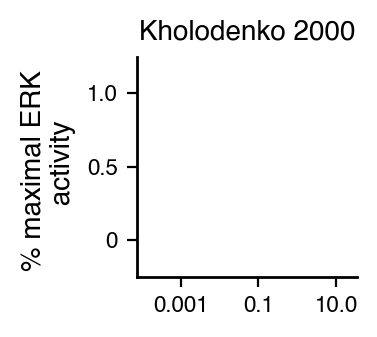

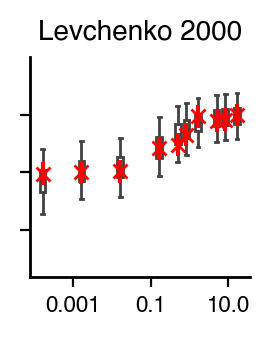

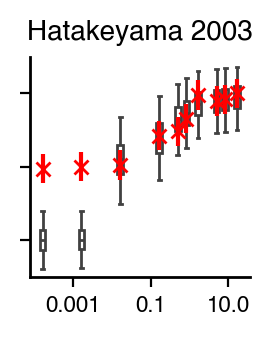

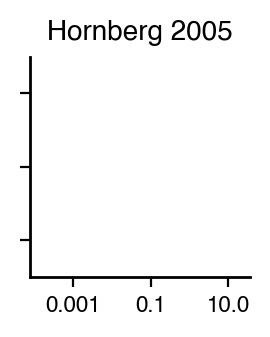

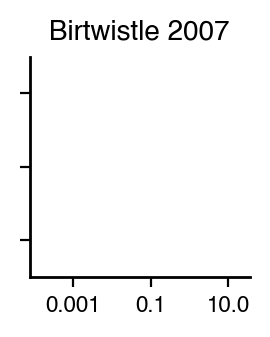

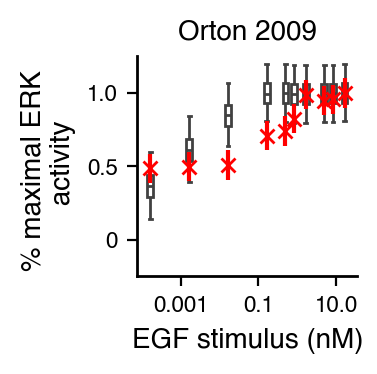

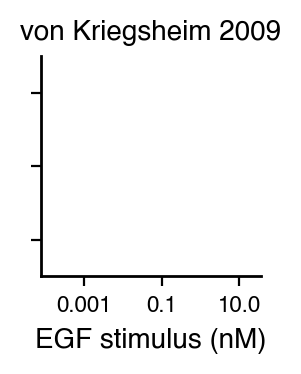

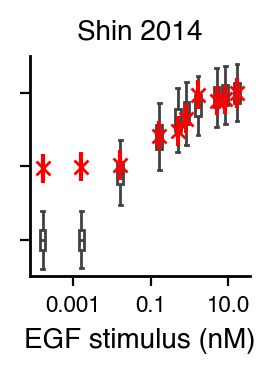

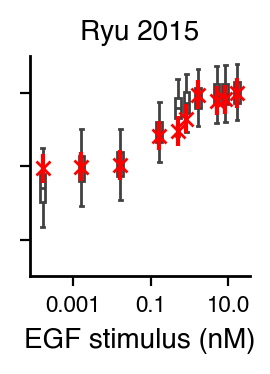

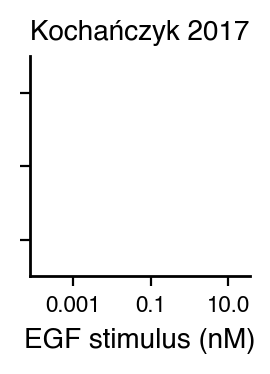

In [ ]:
# fig, ax = plot_stimulus_response_curve(K_2000_post, data, inputs, input_name='EGF stimulus (nM)', 
#                                  output_name='% maximal ERK \n activity', box_color='w', data_color='r',
#                                  data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
# ax.set_ylim([-0.25, 1.25])
# ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
# ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# # ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_xlabel('')
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
# ax.set_title('Kholodenko 2000', fontsize=10.0)

fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '0.5', '1.0'], fontsize=8)
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
# ax.set_xlabel('EGF stimulus (nM)', fontsize=10.0)
ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_xlim([7.745996376990207e-05, 35.293858931387774])
ax.set_title('Kholodenko 2000', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/K_2000_posterior_predictive.pdf', transparent=True)


fig, ax = plot_stimulus_response_curve(L_2000_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
# ax.set_ylim([-0.25, 1.25])
print(ax.get_ylim())
ax.set_yticks([0, 0.5, 1.0])
ax.set_xscale('log')
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
# ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Levchenko 2000', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/L_2000_posterior_predictive.pdf', transparent=True)

print(ax.get_xlim())
fig, ax = plot_stimulus_response_curve(HK_2003_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Hatakeyama 2003', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/HK_2003_posterior_predictive.pdf', transparent=True)

# TODO: Hornberg 2005
fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
# ax.set_xlabel('EGF stimulus (nM)', fontsize=10.0)
ax.set_xlim([7.745996376990207e-05, 35.293858931387774507658])
# ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Hornberg 2005', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/H_2005_posterior_predictive.pdf', transparent=True)

# TODO: Birtwistle 2007
fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
# ax.set_xlabel('EGF stimulus (nM)', fontsize=10.0)
ax.set_xlim([7.745996376990207e-05, 35.293858931387774507658])
# ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Birtwistle 2007', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/B_2007_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(O_2009_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '0.5', '1.0'], fontsize=8)
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_title('Orton 2009', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/O_2009_posterior_predictive.pdf', transparent=True)

# TODO: von Kriegsheim 2009
fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
ax.set_xlabel('EGF stimulus (nM)', fontsize=10.0)
# ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_xlim([7.745996376990207e-05, 35.293858931387774])
ax.set_ylabel('')
ax.set_title('von Kriegsheim 2009', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/VK_2009_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(S_2014_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Shin 2014', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/S_2014_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(R_2015_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Ryu 2015', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/R_2015_posterior_predictive.pdf', transparent=True)

fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
ax.set_xlabel('EGF stimulus (nM)', fontsize=10.0)
# ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_xlim([7.745996376990207e-05, 35.293858931387774])
ax.set_ylabel('')
ax.set_title('Kochańczyk 2017', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/K_2017_posterior_predictive.pdf', transparent=True)